In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SBBBBBSB'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    482.0|    49.3|   -99.45|       SNWD|CA005010191|     0|[80 5F D0 5F 88 6...|2004.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       SNWD|CA005010191|    19|[00 7E C4 60 00 7...|2009.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       SNWD|CA005010191|     0|[24 60 24 60 24 6...|2010.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       SNWD|CA005010191|     0|[1C 63 1C 63 1C 6...|2011.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       SNWD|CA005010191|     7|[60 54 60 54 60 5...|2012.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

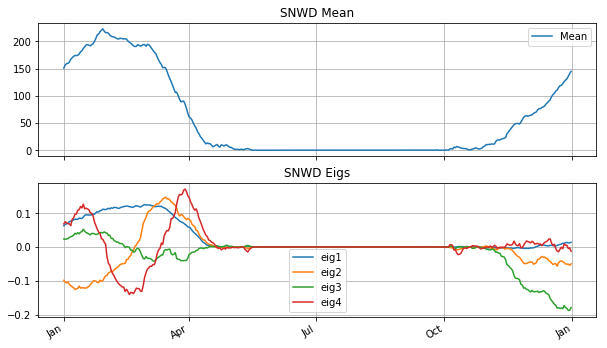

In [10]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
fig.savefig('result_plots/' + m+' Eigs')

In [8]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

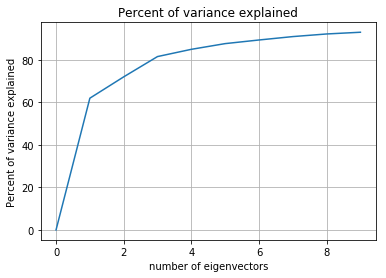

In [9]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [16]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    print residuals[:5]
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [17]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1122
after filter 798


In [18]:
# Sort entries by increasing values of res_3
df3=df3.sort(df3.res_3,ascending=True)

In [19]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10), fig_title=None):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False)
    fig.suptitle(fig_title, fontsize=15)
    fig.savefig('result_plots/' + fig_title)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [20]:
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
rows=df4.take(12)
df4.select('coeff_2','res_2').show(4)

+-------------------+-------------------+
|            coeff_2|              res_2|
+-------------------+-------------------+
| -2474.343837763372|0.15226203263922203|
| -2131.991742401527| 0.0972204523308136|
|-2038.9515394964458| 0.3721833170652798|
|-1940.8203460728234| 0.1186182207651901|
+-------------------+-------------------+
only showing top 4 rows



//anaconda/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


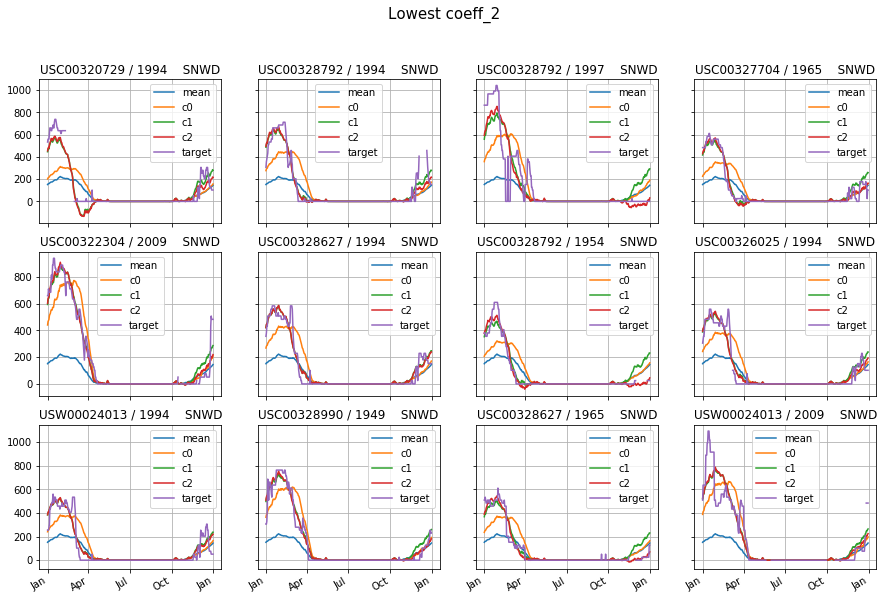

In [21]:
plot_recon_grid(rows, fig_title='Lowest coeff_2')

In [22]:
df3.sort?

In [23]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df5.take(12)
df5.select('coeff_2','res_2').show(4)

+------------------+--------------------+
|           coeff_2|               res_2|
+------------------+--------------------+
|3012.2723826837873|0.042150728494434235|
| 2332.762321492246|0.028307141724792043|
|2030.4897563805164| 0.02866826473496558|
|  1877.12103354436|  0.0958536794139149|
+------------------+--------------------+
only showing top 4 rows



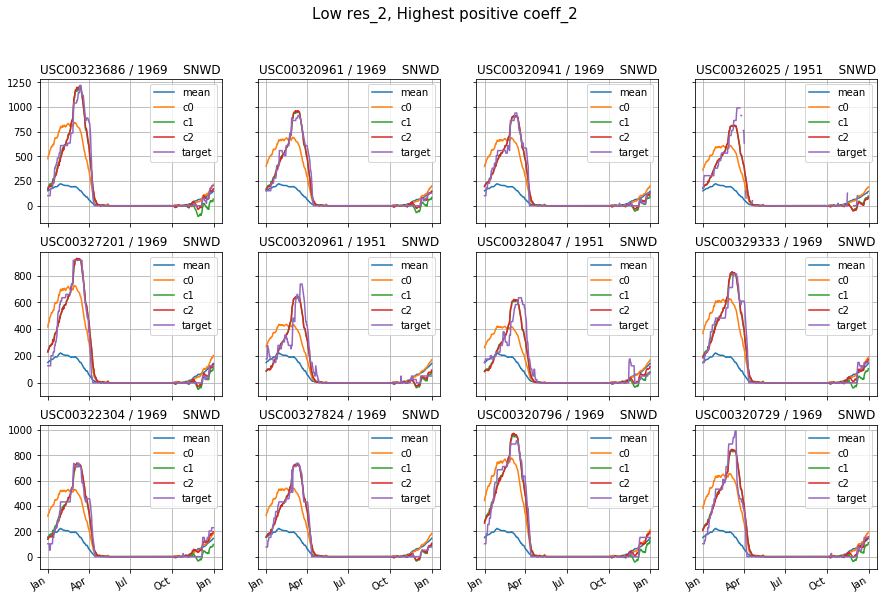

In [24]:
plot_recon_grid(rows, fig_title='Low res_2, Highest positive coeff_2')

# Big residue

In [25]:
df5=df3.sort(df3.res_3,ascending=False)
rows=df5.take(12)
df5.select('coeff_3','res_3').show(4)

+------------------+------------------+
|           coeff_3|             res_3|
+------------------+------------------+
|484.52339277798427| 1.387564965782008|
| 127.5469704856797|1.3373477443723523|
|-36.50430674929386| 1.316340601356853|
| 233.1565179692064|1.2894365016668548|
+------------------+------------------+
only showing top 4 rows



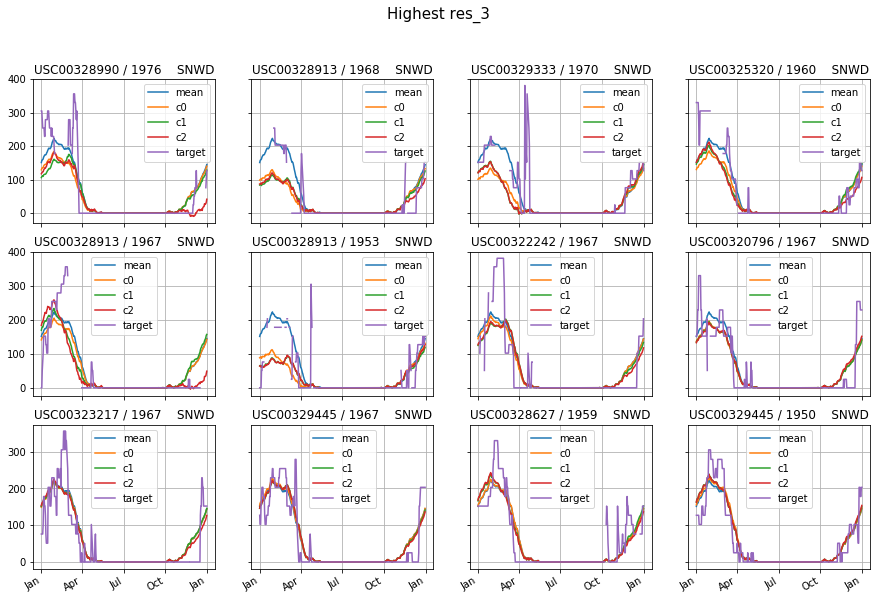

In [26]:
plot_recon_grid(rows, fig_title='Highest res_3')

# Big residue res_1

In [27]:
df4=df3.sort(df3.res_1, ascending=False)
rows=df4.take(12)
df4.select('coeff_1','res_1').show(4)

+------------------+------------------+
|           coeff_1|             res_1|
+------------------+------------------+
|-333.9036086967105|1.5342297382361325|
|-348.2337890746778| 1.463324231476227|
| -797.682290535669|1.3484693582789395|
| -841.045848018406|1.3136469816712513|
+------------------+------------------+
only showing top 4 rows



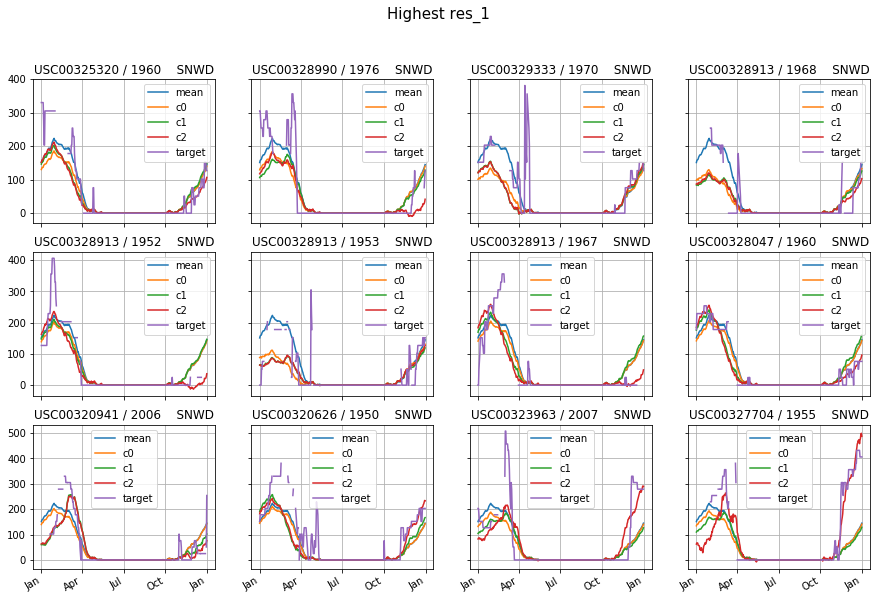

In [28]:
plot_recon_grid(rows, fig_title='Highest res_1')

# Less residue res_1

In [29]:
df4=df3.sort(df3.res_1, ascending=True)
rows=df4.take(12)
df4.select('coeff_1', 'coeff_2', 'coeff_3', 'res_1').show(4)

+------------------+-------------------+-------------------+--------------------+
|           coeff_1|            coeff_2|            coeff_3|               res_1|
+------------------+-------------------+-------------------+--------------------+
| 5497.052338742256|  120.0637413797504|   131.095416157418|0.023803226137587934|
|10654.437235015943|  680.6077462625848|  561.2750530623829|0.023861957275659037|
| 6353.699848118789|-344.27846680717084|-108.91044754282707| 0.03084589624537188|
| 7847.697671352092| -1086.091551196239|  520.6492394782248| 0.04042230227839601|
+------------------+-------------------+-------------------+--------------------+
only showing top 4 rows



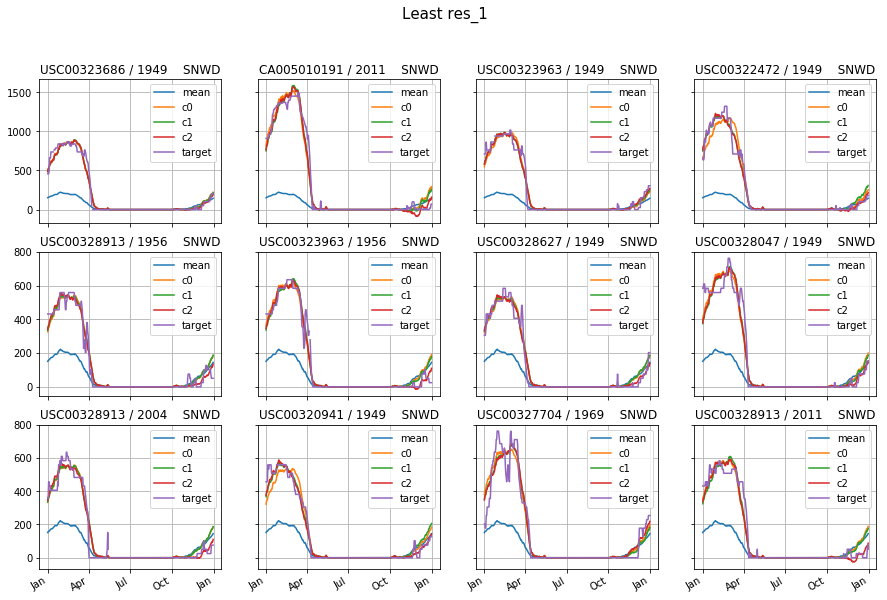

In [30]:
plot_recon_grid(rows, fig_title='Least res_1')

# Big residue res_3

In [31]:
df4=df3.sort(df3.res_3, ascending=False)
rows=df4.take(12)
df4.select('coeff_3','res_3').show(4)

+------------------+------------------+
|           coeff_3|             res_3|
+------------------+------------------+
|484.52339277798427| 1.387564965782008|
| 127.5469704856797|1.3373477443723523|
|-36.50430674929386| 1.316340601356853|
| 233.1565179692064|1.2894365016668548|
+------------------+------------------+
only showing top 4 rows



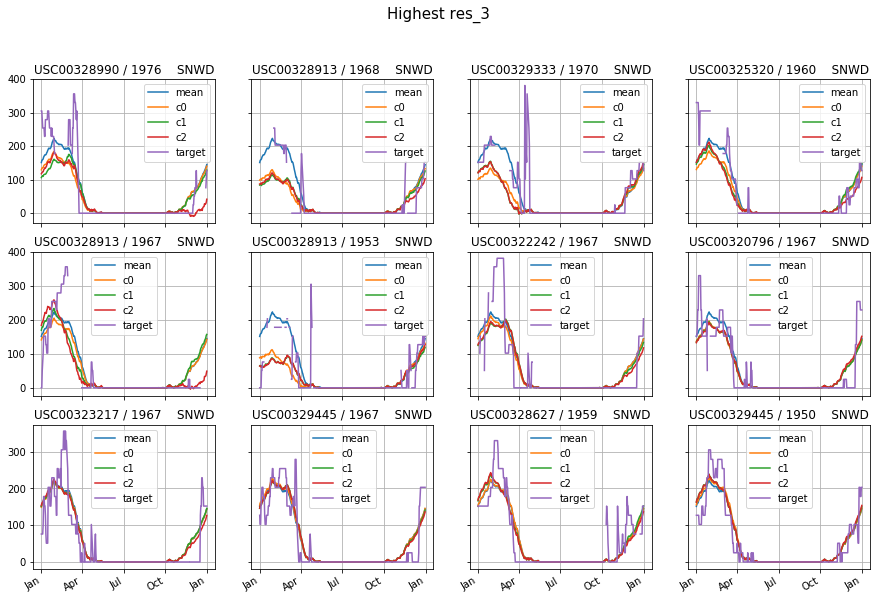

In [32]:
plot_recon_grid(rows, fig_title='Highest res_3')

# Less residue res_3

In [33]:
df4=df3.sort(df3.res_3, ascending=True)
rows=df4.take(12)
df4.select('coeff_1', 'coeff_2', 'coeff_3','res_3').show(4)

+------------------+------------------+-------------------+--------------------+
|           coeff_1|           coeff_2|            coeff_3|               res_3|
+------------------+------------------+-------------------+--------------------+
|10654.437235015943| 680.6077462625848|  561.2750530623829| 0.01716969405073687|
| 7847.697671352092|-1086.091551196239|  520.6492394782248|0.019525748944907186|
|2782.6247450942087|1721.6635066302429|-41.413215052243274|0.021483733567389265|
|3991.8662847501528| 2332.762321492246|-345.68523220822925|0.022875283225776265|
+------------------+------------------+-------------------+--------------------+
only showing top 4 rows



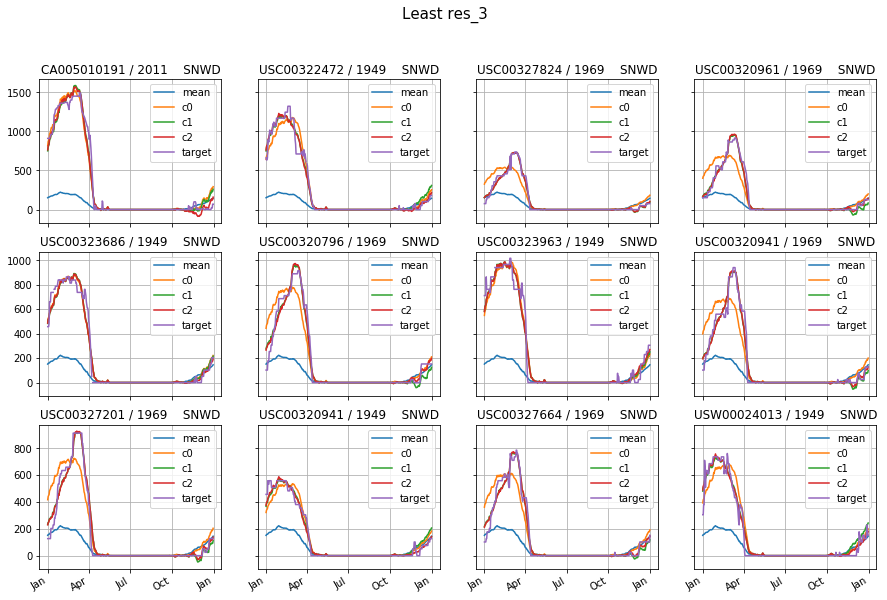

In [34]:
plot_recon_grid(rows, fig_title='Least res_3')

# Big Positive coeff_1

In [35]:
df4=df3.sort(df3.coeff_1, ascending=False)
rows=df4.take(12)
df4.select('coeff_1','res_1').show(4)
# More coeff_1 less res_1 as both have similar shape

+------------------+--------------------+
|           coeff_1|               res_1|
+------------------+--------------------+
|10654.437235015943|0.023861957275659037|
| 7847.697671352092| 0.04042230227839601|
| 6353.699848118789| 0.03084589624537188|
| 5497.052338742256|0.023803226137587934|
+------------------+--------------------+
only showing top 4 rows



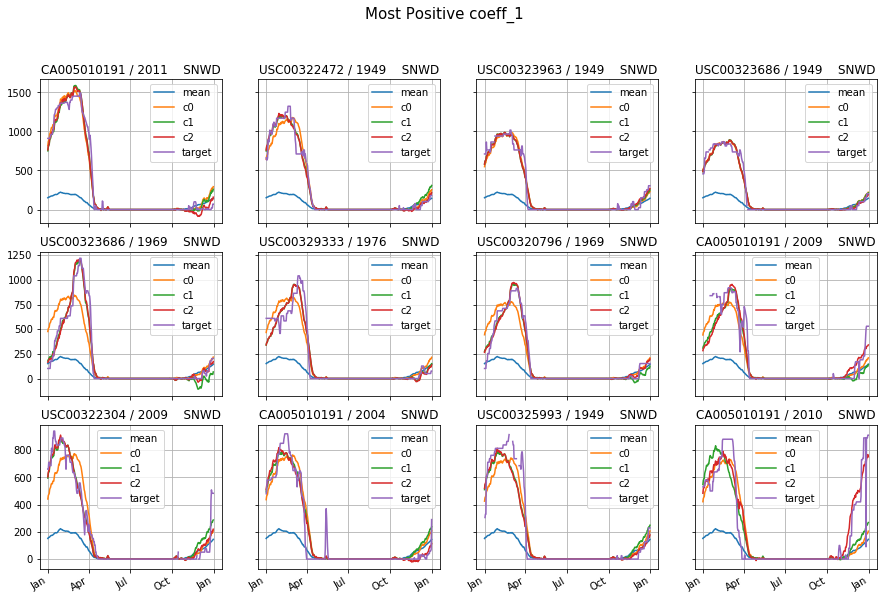

In [36]:
plot_recon_grid(rows, fig_title='Most Positive coeff_1')

# Big Negative coeff_1

In [37]:
df4=df3.sort(df3.coeff_1, ascending=True)
rows=df4.take(12)
df4.select('coeff_1','res_1').show(4)

+-------------------+-------------------+
|            coeff_1|              res_1|
+-------------------+-------------------+
|-1501.4376472256629| 0.6952112519270661|
|-1356.3903430604341| 0.6791598103102547|
|-1303.6264144122651| 0.5234168644785294|
|-1302.1613782007307|0.47220994039898756|
+-------------------+-------------------+
only showing top 4 rows



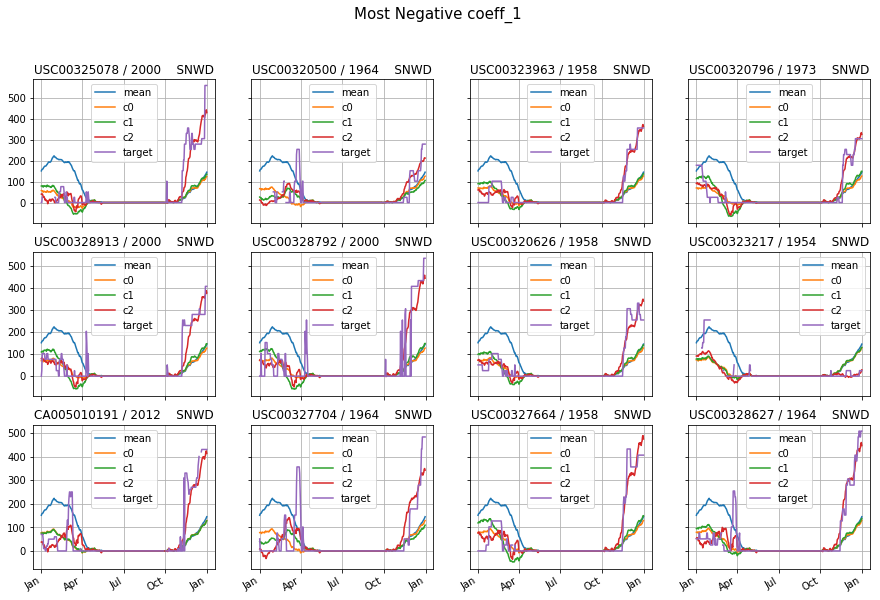

In [38]:
plot_recon_grid(rows, fig_title='Most Negative coeff_1')

# Big Positive coeff_2

In [39]:
df4=df3.sort(df3.coeff_2, ascending=False)
rows=df4.take(12)
df4.select('coeff_2','res_2').show(4)

+------------------+--------------------+
|           coeff_2|               res_2|
+------------------+--------------------+
|3012.2723826837873|0.042150728494434235|
| 2332.762321492246|0.028307141724792043|
|2273.9292511501853| 0.43606160753855094|
|2030.4897563805164| 0.02866826473496558|
+------------------+--------------------+
only showing top 4 rows



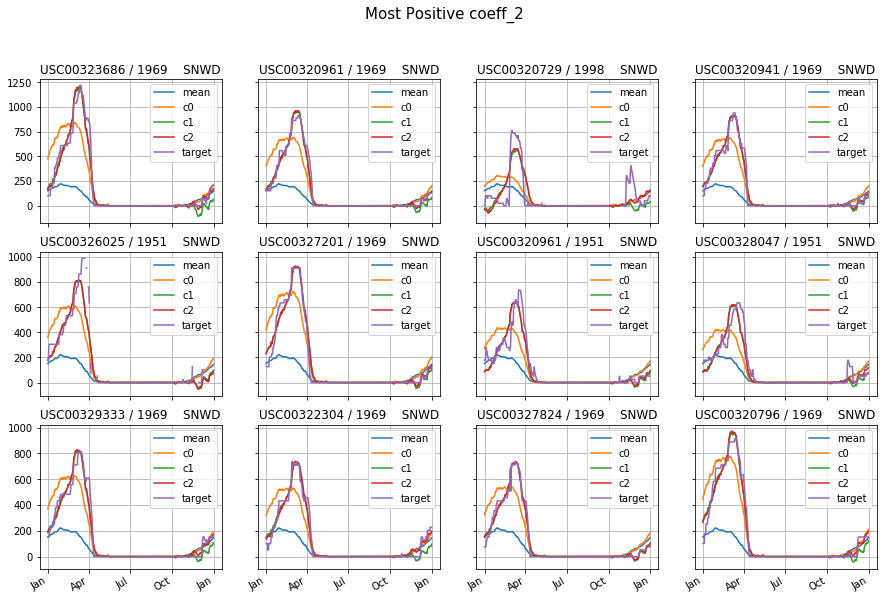

In [40]:
plot_recon_grid(rows, fig_title='Most Positive coeff_2')

# Big Negative coeff_2

In [41]:
df4=df3.sort(df3.coeff_2, ascending=True)
rows=df4.take(12)
df4.select('coeff_1','res_1').show(4)

+------------------+------------------+
|           coeff_1|             res_1|
+------------------+------------------+
| 805.1345450879144| 0.837674991694739|
|  1995.62837785769|0.5939679328244114|
|459.56627491331966|0.9866080157490582|
| 3291.054475050839|0.5463208786753428|
+------------------+------------------+
only showing top 4 rows



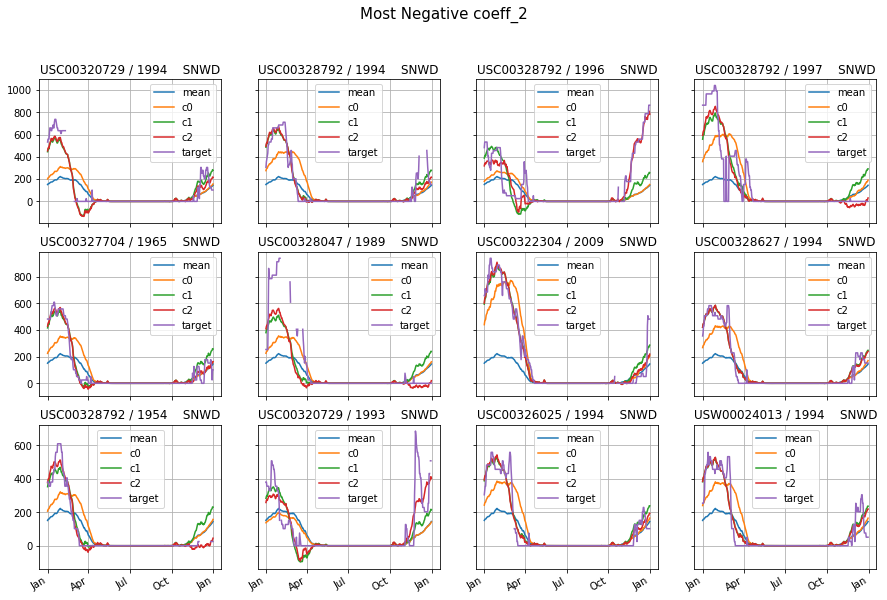

In [42]:
plot_recon_grid(rows, fig_title='Most Negative coeff_2')

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.875053192827
residual normalized norm  after mean + top eigs: [ 0.69521125  0.67099658  0.1522783 ]


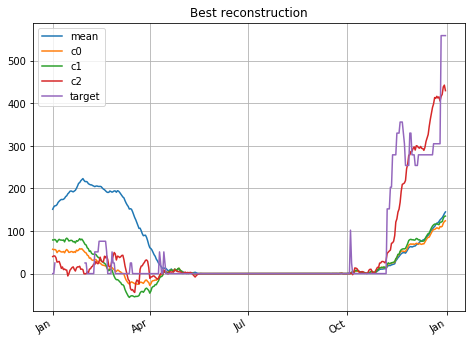

In [43]:
# WTF, wrong coeffs.?


df4=df3.sort(df3.coeff_1, ascending=True)
rows=df4.take(12)
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [49]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
#     vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat + ' for '+ m)
    ylabel('number of instances')
    xlabel(feat)
    grid()
    savefig('result_plots/cumulative distribution of '+feat + ' for '+ m)

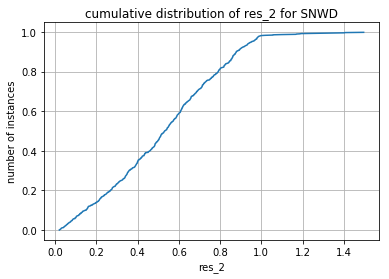

In [50]:
plot_CDF('res_2')

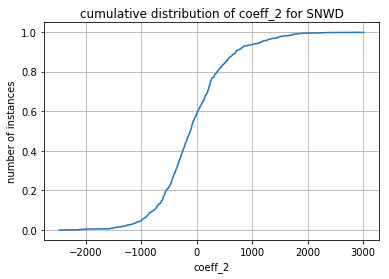

In [51]:
plot_CDF('coeff_2')

In [52]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [48]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.4M	../../Data/Weather/US_Weather_SBBBBBSB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.9M	../../Data/Weather/decon_SBBBBBSB_PRCP.parquet
2.3M	../../Data/Weather/decon_SBBBBBSB_SNWD.parquet


In [140]:
df5=df3.filter(df3.res_2>1).sort(df3.res_2,ascending=False)

In [141]:
df5.select('res_2').show(30)

+------------------+
|             res_2|
+------------------+
| 1.496744970281094|
|1.4061992498129579|
| 1.402826638341109|
|1.3206774029256438|
|1.2580683113660263|
| 1.193213722561988|
|1.1875603095831406|
|1.1701737513813493|
|  1.16839561872529|
|1.1000272373671898|
| 1.056917501298468|
|1.0562596203160801|
| 1.018709874024187|
+------------------+



In [145]:
df3.count()

798

In [143]:
eigvals

array([  6.19487814e-01,   1.00246774e-01,   9.54510153e-02,
         3.40662397e-02,   2.68310895e-02,   1.70585871e-02,
         1.59809149e-02,   1.23358001e-02,   8.12067015e-03,
         7.49927566e-03,   5.41961403e-03,   5.04784205e-03,
         4.68711756e-03,   3.99447069e-03,   3.74310662e-03,
         3.23014747e-03,   2.77826062e-03,   2.63481978e-03,
         2.24701780e-03,   1.97555208e-03,   1.80271951e-03,
         1.63402106e-03,   1.51369676e-03,   1.45868314e-03,
         1.32709151e-03,   1.12502284e-03,   1.08888998e-03,
         9.86094138e-04,   9.81034844e-04,   8.84146681e-04,
         8.70686118e-04,   7.80273121e-04,   6.65893143e-04,
         6.42408800e-04,   6.28983526e-04,   6.02744984e-04,
         5.39554309e-04,   5.06560419e-04,   4.77672364e-04,
         4.61675664e-04,   4.41982960e-04,   4.28935618e-04,
         4.09840349e-04,   3.99647099e-04,   3.88140611e-04,
         3.63483901e-04,   3.47213830e-04,   3.29453623e-04,
         3.17451023e-04,